This is an old blog post, see the newer version in [this post](http://blog.invibe.net/posts/2017-03-14-reproducing-olshausens-classical-sparsenet.html) and following.


<!-- TEASER_END -->

In this notebook, we write an example script for the ``sklearn`` library showing the improvement in the convergence of dictionary learning induced by the introduction of Olshausen's homeostasis.

See also :
* http://blog.invibe.net/posts/2015-05-05-reproducing-olshausens-classical-sparsenet.html for a description of how SparseNet is implemented in the scikit-learn package
* http://blog.invibe.net/posts/2015-05-06-reproducing-olshausens-classical-sparsenet-part-2.html for a description of how we managed to implement the homeostasis
* http://blog.invibe.net/posts/2015-12-11-reproducing-olshausens-classical-sparsenet-part-3.html for a description of the role of the homeostasis' parameters


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=2, suppress=True)

In [12]:
%%writefile ~/pool/libs/numbers/scikit-learn-sparsenet/examples/decomposition/plot_sparsenet.py

"""
=======================================
Dictionary learning using Sparse coding
=======================================

This example compares the set of filters obtained by sparse coding 
algorithm described by Olshausen and Field in Nature, vol. 381,
pp. 607-609 with that obtained using :ref:`DictionaryLearning`. The
main differences lying in the different strategies to control the norm
of the filters during the learning phase, that is by the homeostasis 
algorithm.

The dictionary is fitted on a natural image using :ref:`omp` with ten
non-zero coefficients as the coding algorithm. Note that qualitatively 
similar results are obtained with other algorithms, but here we focus on
the role of the homeostasis algorithm.

Indeed, the unsupervised learning algorithm starts with a random set of 
filters and then slowly adapts them such that they are closer to the input
(here, patches from natural images). However, filters that learn first are 
more likely to be subsequently selected and some regulation mechanism is
necessary such that all atoms from the dictionary learn equally.
The most basic mechanism, as implemented in  :ref:`DictionaryLearning`,
is to normalize the energy of each atom to a given value (for instance to 1).

It can be seen from the plots that the results of :ref:`DictionaryLearning`
without homeostasis leads to the emergence of edge-like filters but that a 
number of filters are not learned: They still are closer to noise and are 
unlikely to be selected by the sparse coding algorithm without homeostasy.
The heuristics used here follows the assumption that during learning,
some elements that learn first are more responsive to input patches
as may be recorded by estimating their mean variance. If we were to
keep their norm fixed, these would be more likely to be selected again,
leading to a ``monopolistic'' distribution of dictionary elements,
some having learned more often than others. 

Following the classical SparseNet algorithm from Olshausen, we
compute in :ref:`SparseHebbianLearning` a "gain vector" for the dictionary. 
This gain is used to tune the weight of each dictionary element during the 
learning phase. By dividing their norm by their mean estimated variance, 
we lower the probability of elements with high variance to be selected again.
This thus helps the learning to be more balanced. The result of 
:ref:`SparseHebbianLearning` is much more balanced: all atoms have been 
selected approximately equally during learning and the dictionary displays
a more homogeneous set of edge filters.

"""
print(__doc__)

from time import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import MiniBatchDictionaryLearning, SparseHebbianLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d


patch_size = (12, 12)
n_components = 14**2
transform_algorithm = 'omp'
n_iter = 10000

###############################################################################
# Load a natural image and extract patches
#import imageio
#image = imageio.imread('https://raw.githubusercontent.com/bicv/SLIP/master/database/yelmo512_w.png')
from sklearn.externals.six.moves.urllib.request import urlopen
opener = urlopen('https://raw.githubusercontent.com/bicv/SLIP/master/database/yelmo512_w.png')
open('/tmp/yelmo512_w.png', 'wb').write(opener.read())
try:
    from scipy.misc import imread
except ImportError:
    from scipy.misc.pilutil import imread
image = imread('/tmp/yelmo512_w.png')
image = image.astype(np.float)
    
# Extract all reference patches from the left half of the image
print('Extracting image patches...')
t0 = time()
data = extract_patches_2d(image, patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print('done in %.2fs.' % (time() - t0))

###############################################################################
# Learn the dictionary from reference patches

print('Learning the dictionary...')
t0 = time()
dico =  MiniBatchDictionaryLearning(n_components=n_components, transform_algorithm=transform_algorithm, n_iter=n_iter)
V = dico.fit(data).components_
dt = time() - t0
print('done in %.2fs.' % dt)

subplotpars = matplotlib.figure.SubplotParams(left=0., right=1., bottom=0., top=1., wspace=0.05, hspace=0.05,)
fig = plt.figure(figsize=(8.4, 8), subplotpars=subplotpars)
for i, comp in enumerate(V[:n_components]):
    plt.subplot(np.sqrt(n_components), np.sqrt(n_components), i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned without homeostasis\n' +
             'Train time %.1fs on %d patches' % (dt, len(data)),
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

###############################################################################
# Learn the dictionary from reference patches

print('Learning the dictionary...')
t0 = time()
dico = SparseHebbianLearning(n_components=n_components, transform_algorithm=transform_algorithm, n_iter=n_iter, 
                             gain_rate=.01)
V = dico.fit(data).components_
dt = time() - t0
print('done in %.2fs.' % dt)

fig = plt.figure(figsize=(8.4, 8), subplotpars=subplotpars)
for i, comp in enumerate(V[:n_components]):
    plt.subplot(np.sqrt(n_components), np.sqrt(n_components), i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned with homeostasis\n' +
             'Train time %.1fs on %d patches' % (dt, len(data)),
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

Overwriting /Users/lolo/pool/libs/numbers/scikit-learn-sparsenet/examples/decomposition/plot_sparsenet.py


/Users/lolo/pool/libs/numbers/scikit-learn-sparsenet/examples/decomposition

Dictionary learning using Sparse coding

This example compares the set of filters obtained by sparse coding 
algorithm described by Olshausen and Field in Nature, vol. 381,
pp. 607-609 with that obtained using :ref:`DictionaryLearning`. The
main differences lying in the different strategies to control the norm
of the filters during the learning phase, that is by the homeostasis 
algorithm.

The dictionary is fitted on a natural image using :ref:`omp` with ten
non-zero coefficients as the coding algorithm. Note that qualitatively 
similar results are obtained with other algorithms, but here we focus on
the role of the homeostasis algorithm.

Indeed, the unsupervised learning algorithm starts with a random set of 
filters and then slowly adapts them such that they are closer to the input
(here, patches from natural images). However, filters that learn first are 
more likely to be subsequently selected and some r

/Users/lolo/pool/libs/numbers/scikit-learn-sparsenet/sklearn/decomposition/dict_learning.py:152: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T


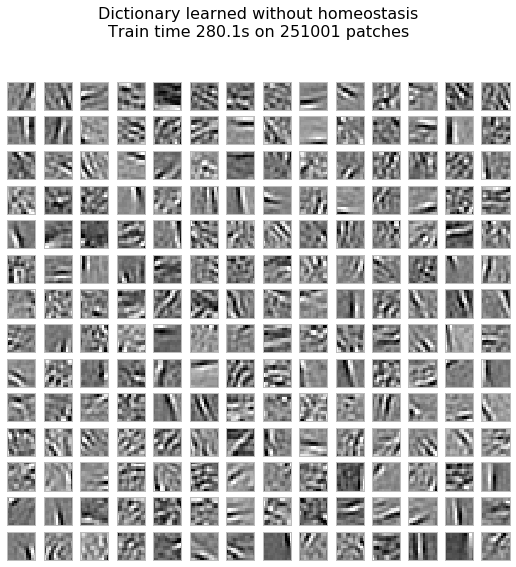

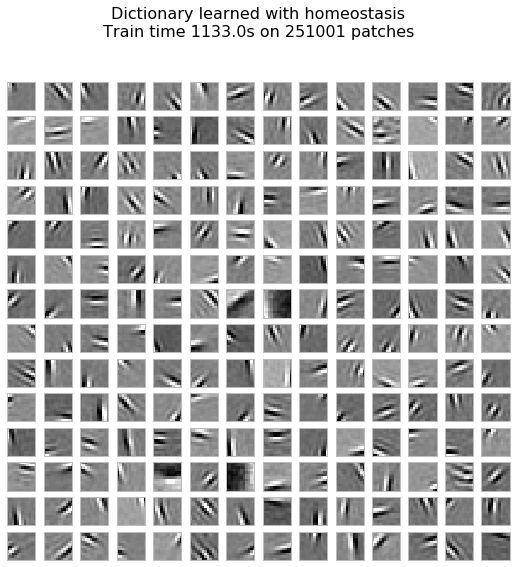

In [13]:
%cd -q ~/pool/libs/numbers/scikit-learn-sparsenet/examples/decomposition/
%run plot_sparsenet.py

In [15]:
!git s

 M plot_sparsenet.py
?? ../../sklearn/sklearn.egg-info/


In [16]:
#!git add plot_sparsenet.py
!git commit -am' adding an example script to see the improvement in dictionary learning : using only standard library '
!git push

[sparsenet 6065e3f]  adding an example script to see the improvement in dictionary learning : using only standard library
 1 file changed, 13 insertions(+), 5 deletions(-)
Counting objects: 5, done.
Delta compression using up to 8 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 710 bytes | 0 bytes/s, done.
Total 5 (delta 4), reused 0 (delta 0)
To https://github.com/laurentperrinet/scikit-learn.git
   68ba6b7..6065e3f  sparsenet -> sparsenet


## Version used

In [17]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%version_information numpy, shl_scripts

Installed version_information.py. To use it, type:
  %load_ext version_information
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.5.1 64bit [GCC 4.2.1 Compatible Apple LLVM 7.0.0 (clang-700.1.76)]
IPython 4.0.0
OS Darwin 15.0.0 x86_64 i386 64bit
numpy 1.10.1
shl_scripts 2.1
Tue Dec 15 16:46:35 2015 CET